# Pubmedbert fine-tuning for ADE classification

**Goal.** Fine-tune Pubmedbert on the cleaned splits, choose a threshold on validation with a recall target, and evaluate on test.

In [ ]:
from pathlib import Path
import os, sys, json, random, inspect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    precision_recall_curve, roc_curve, auc,
    average_precision_score, roc_auc_score,
    brier_score_loss, confusion_matrix
)
from sklearn.calibration import calibration_curve

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, Trainer, TrainingArguments, EarlyStoppingCallback
)


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

# project root + src (same pattern as NB4)
CANDIDATES = [
    Path("/content/drive/MyDrive/masters_math/capestone/Final_project/Final_project"),
    Path("/content/drive/masters_math/capestone/Final_project/Final_project"),
]
PROJECT_ROOT = next((p for p in CANDIDATES if (p/"src"/"utilities.py").exists()), None)
assert PROJECT_ROOT, "Couldn't find src/utilities.py. Check the Drive path."
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
import importlib, src; importlib.reload(src)

from src import (
    set_seed, ensure_dir, choose_text_col, compute_class_weights, save_json,
    plot_confusion, pick_thr_with_recall_floor
)
from src.hf_utils import token_length_stats, make_hf_datasets, WeightedTrainer

# dirs + seed
ARTIFACTS_DIR = ensure_dir(PROJECT_ROOT / "artifacts")
PLOTS_DIR     = ensure_dir(PROJECT_ROOT / "plots")
TRANS_DIR     = ensure_dir(ARTIFACTS_DIR / "transformers" / "biobert")
set_seed(42)
plt.rcParams["figure.dpi"] = 150

BIO_MODEL_ID = "dmis-lab/biobert-base-cased-v1.1"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data Load**

In [ ]:
train_df = pd.read_csv(ARTIFACTS_DIR / "train_clean.csv")
val_df   = pd.read_csv(ARTIFACTS_DIR / "val_clean.csv")
test_df  = pd.read_csv(ARTIFACTS_DIR / "test_clean.csv")

TEXT_COL  = choose_text_col(train_df, "text_clean")
LABEL_COL = "label"

for df, name in [(train_df,"train"), (val_df,"val"), (test_df,"test")]:
    assert {TEXT_COL, LABEL_COL}.issubset(df.columns), f"{name} missing columns"
    if "uid" not in df.columns:
        df["uid"] = [f"{name[:2]}_{i:05d}" for i in range(len(df))]

print({"train": train_df.shape, "val": val_df.shape, "test": test_df.shape, "text_col": TEXT_COL})


{'train': (13743, 7), 'val': (1527, 7), 'test': (5626, 7), 'text_col': 'text_clean'}


**Tokenizer + datasets (PubMedBERT)**

In [ ]:
# PubMedBERT model ID (abstracts)
PUB_MODEL_ID = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"

pub_tok = AutoTokenizer.from_pretrained(PUB_MODEL_ID, use_fast=True)

# token lengths on train (q95, q99) and chosen MAX_LEN
stats = token_length_stats(pub_tok, train_df[TEXT_COL])
p95_tok, p99_tok = stats["q95"], stats["q99"]
MAX_LEN = 320
print(f"token length p95={p95_tok}, p99={p99_tok} | using MAX_LEN={MAX_LEN}")

# encoded datasets
ds_train, ds_val, ds_test, d_collator = make_hf_datasets(
    train_df, val_df, test_df, text_col=TEXT_COL, tokenizer=pub_tok, max_len=MAX_LEN
)
print(f"datasets: train={len(ds_train)}, val={len(ds_val)}, test={len(ds_test)}")


token length p95=45, p99=61 | using MAX_LEN=320
datasets: train=13743, val=1527, test=5626


Compute token-length stats on train (q95/q99) and cap at MAX_LEN = 320.

Use DataCollatorWithPadding for dynamic padding to each batch’s max length; truncate beyond MAX_LEN.

# **training setup + train (PubMedBERT)**

Loss: class-weighted cross entropy to handle imbalance.

Optimization: AdamW, learning rate 5e-5, weight decay 0.01, 200 warmup steps, fp16 when available.

Schedule/early stop: evaluate & save each epoch, early stopping (patience=2) on validation recall, and load best model at end.

Batches: train 16, eval 64.

In [ ]:
# write PubMedBERT artifacts to folder
TRANS_DIR = ensure_dir(ARTIFACTS_DIR / "transformers" / "pubmedbert")

# class weights from train
cw = compute_class_weights(train_df[LABEL_COL])  # [w0, w1] ndarray

# version-safe TrainingArguments (same spirit as NB4/NB5)
def build_targs(**kw):
    sig = inspect.signature(TrainingArguments.__init__).parameters
    out = dict(
        output_dir=kw.get("output_dir"),
        num_train_epochs=kw.get("num_train_epochs", 10),
        per_device_train_batch_size=kw.get("per_device_train_batch_size", 16),
        per_device_eval_batch_size=kw.get("per_device_eval_batch_size", 64),
        logging_dir=kw.get("logging_dir"),
        logging_steps=50,
        report_to="none",
        warmup_steps=200,
        weight_decay=0.01,
        save_total_limit=2,
        seed=kw.get("seed", 42),
        fp16=kw.get("fp16", torch.cuda.is_available()),
        learning_rate=kw.get("learning_rate", 5e-5),
    )
    if "evaluation_strategy" in sig: out["evaluation_strategy"] = "epoch"
    elif "eval_strategy" in sig:     out["eval_strategy"] = "epoch"
    if "save_strategy" in sig:             out["save_strategy"] = "epoch"
    if "load_best_model_at_end" in sig:    out["load_best_model_at_end"] = True
    if "metric_for_best_model" in sig:     out["metric_for_best_model"]  = kw.get("select_metric", "eval_recall")
    if "greater_is_better" in sig:         out["greater_is_better"]      = kw.get("greater_is_better", True)
    return TrainingArguments(**out)

pub_args = build_targs(
    output_dir=str(TRANS_DIR / "results"),
    logging_dir=str(TRANS_DIR / "logs"),
    num_train_epochs=10,
    seed=42,
    select_metric="eval_recall",
    greater_is_better=True,
    learning_rate=5e-5
)

# metrics that also log PR/ROC AUC (version-safe on EvalPrediction/tuple)
def compute_metrics(eval_pred):
    logits, labels = eval_pred if isinstance(eval_pred, tuple) else (eval_pred.predictions, eval_pred.label_ids)
    if isinstance(logits, tuple): logits = logits[0]
    probs = torch.softmax(torch.tensor(logits), dim=1).numpy()[:, 1]
    y_pred = np.asarray(logits).argmax(-1)
    p, r, f1, _ = precision_recall_fscore_support(labels, y_pred, average="binary", zero_division=0)
    acc = accuracy_score(labels, y_pred)
    ap  = average_precision_score(labels, probs)
    ra  = roc_auc_score(labels, probs)
    return {"accuracy": acc, "f1": f1, "precision": p, "recall": r, "pr_auc": ap, "roc_auc": ra}

# patch WeightedTrainer to accept new kwargs like num_items_in_batch
class PatchedWeightedTrainer(WeightedTrainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits", outputs[0])
        weight = getattr(self, "class_weights", None)
        if weight is not None:
            weight = torch.tensor(weight, dtype=torch.float).to(logits.device) if not torch.is_tensor(weight) else weight.to(logits.device)
        loss_fct = torch.nn.CrossEntropyLoss(weight=weight)
        loss = loss_fct(logits.view(-1, 2), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

pub_model = AutoModelForSequenceClassification.from_pretrained(PUB_MODEL_ID, num_labels=2)

trainer = PatchedWeightedTrainer(
    model=pub_model,
    args=pub_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    data_collator=d_collator,
    tokenizer=pub_tok,
    compute_metrics=compute_metrics,
    class_weights=cw
)

trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=2))

_ = trainer.train()
print("best_checkpoint:", trainer.state.best_model_checkpoint)
print("best eval_recall:", trainer.state.best_metric)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/src/hf_utils.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `PatchedWeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Pr Auc,Roc Auc
1,0.275900,0.364196,0.929928,0.809947,0.817204,0.802817,0.883992,0.969689
2,0.254400,0.232711,0.937787,0.846527,0.782090,0.922535,0.927376,0.980226
3,0.153600,0.494749,0.947610,0.856115,0.875000,0.838028,0.908495,0.973651
4,0.077900,0.437053,0.941716,0.847863,0.823920,0.873239,0.909862,0.979407


best_checkpoint: /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts/transformers/pubmedbert/results/checkpoint-1718
best eval_recall: 0.9225352112676056


# **probs (VAL/TEST) + recall-floor threshold**
Threshold selection (VAL): recall floor 0.90, pick max-F1 with precision tie-break.

In [ ]:
def get_labels_probs(trainer, dataset):
    out = trainer.predict(dataset)
    logits = out.predictions if not isinstance(out.predictions, tuple) else out.predictions[0]
    probs = torch.softmax(torch.tensor(logits), dim=1).numpy()[:, 1]
    return out.label_ids, probs

d_val_y,  d_val_p  = get_labels_probs(trainer, ds_val)
d_test_y, d_test_p = get_labels_probs(trainer, ds_test)

RECALL_FLOOR = 0.900
tv_pub_thr, stats = pick_thr_with_recall_floor(d_val_y, d_val_p, floor=RECALL_FLOOR)

print("VAL threshold:", f"{tv_pub_thr:.3f}")
print("VAL metrics at chosen threshold:",
      f"Precision={stats['precision']:.3f} | Recall={stats['recall']:.3f} | F1={stats['f1']:.3f} | PR-AUC={stats['pr_auc']:.3f}")


VAL threshold: 0.876
VAL metrics at chosen threshold: Precision=0.829 | Recall=0.905 | F1=0.865 | PR-AUC=0.927


# **save artifacts (model/tokenizer/preds/metrics)**

In [ ]:
MODEL_DIR = ensure_dir(TRANS_DIR / "model")
PRED_DIR  = ensure_dir(TRANS_DIR / "preds")

# model + tokenizer
trainer.model.save_pretrained(MODEL_DIR)
pub_tok.save_pretrained(MODEL_DIR)

# stable IDs from the split
va_ids = val_df["uid"].astype(str).values
te_ids = test_df["uid"].astype(str).values

pd.DataFrame({"id": va_ids, "y_true": d_val_y,  "y_score": d_val_p}).to_csv(PRED_DIR/"val_probs.csv",  index=False)
pd.DataFrame({"id": te_ids, "y_true": d_test_y, "y_score": d_test_p}).to_csv(PRED_DIR/"test_probs.csv", index=False)

def pr_auc(y,p):
    pr_p, pr_r, _ = precision_recall_curve(y,p); return float(auc(pr_r, pr_p))
val_ap  = pr_auc(d_val_y, d_val_p)
test_ap = pr_auc(d_test_y, d_test_p)

d_test_hat = (d_test_p >= tv_pub_thr).astype(int)
tP, tR, tF1, _ = precision_recall_fscore_support(d_test_y, d_test_hat, average="binary", zero_division=0)
tAcc = accuracy_score(d_test_y, d_test_hat)

save_json({"strategy":"recall_floor","floor":float(RECALL_FLOOR),
           "best_threshold":float(tv_pub_thr)}, TRANS_DIR/"thresholds.json")

save_json({"pr_auc": val_ap,
           "val_at_best": {"precision": float(stats["precision"]), "recall": float(stats["recall"]),
                           "f1": float(stats["f1"]), "thr": float(tv_pub_thr)}},
          TRANS_DIR/"metrics_val.json")

save_json({"threshold": float(tv_pub_thr), "precision": float(tP), "recall": float(tR),
           "f1": float(tF1), "accuracy": float(tAcc), "pr_auc": float(test_ap)},
          TRANS_DIR/"metrics_test.json")

print("Saved:", {"model_dir": str(MODEL_DIR),
                "preds": [str(PRED_DIR/'val_probs.csv'), str(PRED_DIR/'test_probs.csv')],
                "thresholds": str(TRANS_DIR/'thresholds.json')})


Saved: {'model_dir': '/content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts/transformers/pubmedbert/model', 'preds': ['/content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts/transformers/pubmedbert/preds/val_probs.csv', '/content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts/transformers/pubmedbert/preds/test_probs.csv'], 'thresholds': '/content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts/transformers/pubmedbert/thresholds.json'}


# **PR/ROC  (VAL & TEST)**

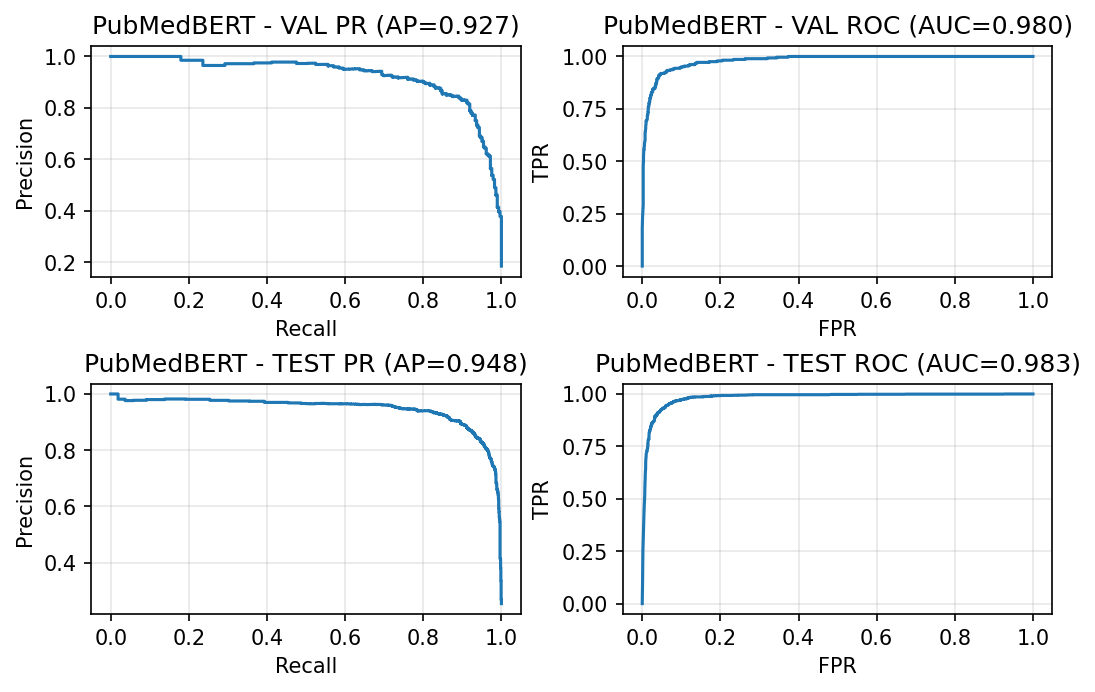

Saved: /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/plots/pubmed_val_test_pr_roc_grid.png


In [ ]:
def plot_val_test_grid(y_va, p_va, y_te, p_te, model_name: str, out_png: Path):
    pr_p_va, pr_r_va, _ = precision_recall_curve(y_va, p_va)
    fpr_va, tpr_va, _   = roc_curve(y_va, p_va)
    pr_p_te, pr_r_te, _ = precision_recall_curve(y_te, p_te)
    fpr_te, tpr_te, _   = roc_curve(y_te, p_te)

    ap_va  = average_precision_score(y_va, p_va)
    ap_te  = average_precision_score(y_te, p_te)
    auc_va = auc(fpr_va, tpr_va)
    auc_te = auc(fpr_te, tpr_te)

    fig, axes = plt.subplots(2, 2, figsize=(7, 4.5), constrained_layout=True)

    ax = axes[0,0]; ax.step(pr_r_va, pr_p_va, where="post")
    ax.set_title(f"{model_name} - VAL PR (AP={ap_va:.3f})"); ax.set_xlabel("Recall"); ax.set_ylabel("Precision"); ax.grid(alpha=0.3)

    ax = axes[0,1]; ax.plot(fpr_va, tpr_va)
    ax.set_title(f"{model_name} - VAL ROC (AUC={auc_va:.3f})"); ax.set_xlabel("FPR"); ax.set_ylabel("TPR"); ax.grid(alpha=0.3)

    ax = axes[1,0]; ax.step(pr_r_te, pr_p_te, where="post")
    ax.set_title(f"{model_name} - TEST PR (AP={ap_te:.3f})"); ax.set_xlabel("Recall"); ax.set_ylabel("Precision"); ax.grid(alpha=0.3)

    ax = axes[1,1]; ax.plot(fpr_te, tpr_te)
    ax.set_title(f"{model_name} - TEST ROC (AUC={auc_te:.3f})"); ax.set_xlabel("FPR"); ax.set_ylabel("TPR"); ax.grid(alpha=0.3)

    out_png.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_png, dpi=200, bbox_inches="tight")
    plt.show()
    print("Saved:", out_png)

plot_val_test_grid(d_val_y, d_val_p, d_test_y, d_test_p,
                   "PubMedBERT", PLOTS_DIR / "pubmed_val_test_pr_roc_grid.png")


PR/ROC: Strong curves on both VAL and TEST (AP=0.93/0.95, AUC=0.98/0.98), with a small generalization gap.

# **Confusion matrix (TEST at VAL-chosen threshold)**

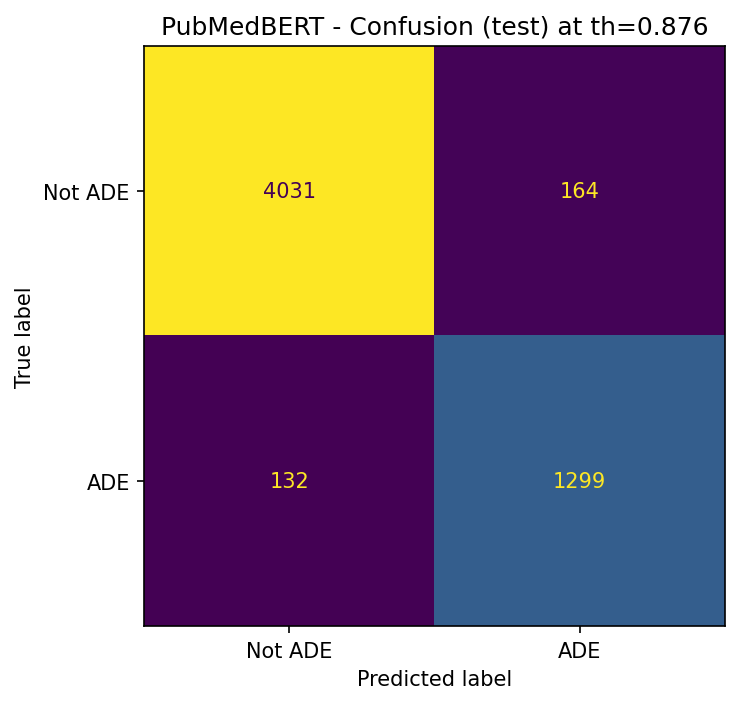

TN, FP, FN, TP = 4031 164 132 1299
Precision=0.888 | Recall=0.908 | F1=0.898 | Accuracy=0.947
Saved: /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/plots/pubmed_test_confusion.png


In [ ]:
y_hat = (d_test_p >= tv_pub_thr).astype(int)
cm = confusion_matrix(d_test_y, y_hat, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
prec = tp / (tp + fp + 1e-12)
rec  = tp / (tp + fn + 1e-12)
f1   = 2 * prec * rec / (prec + rec + 1e-12)
acc  = (tp + tn) / cm.sum()

out_cm = PLOTS_DIR / "pubmed_test_confusion.png"
plot_confusion(d_test_y, y_hat, out_cm, title=f"PubMedBERT - Confusion (test) at th={tv_pub_thr:.3f}")

print("TN, FP, FN, TP =", tn, fp, fn, tp)
print(f"Precision={prec:.3f} | Recall={rec:.3f} | F1={f1:.3f} | Accuracy={acc:.3f}")
print("Saved:", out_cm)


# **Calibration curve + score histogram (TEST)**

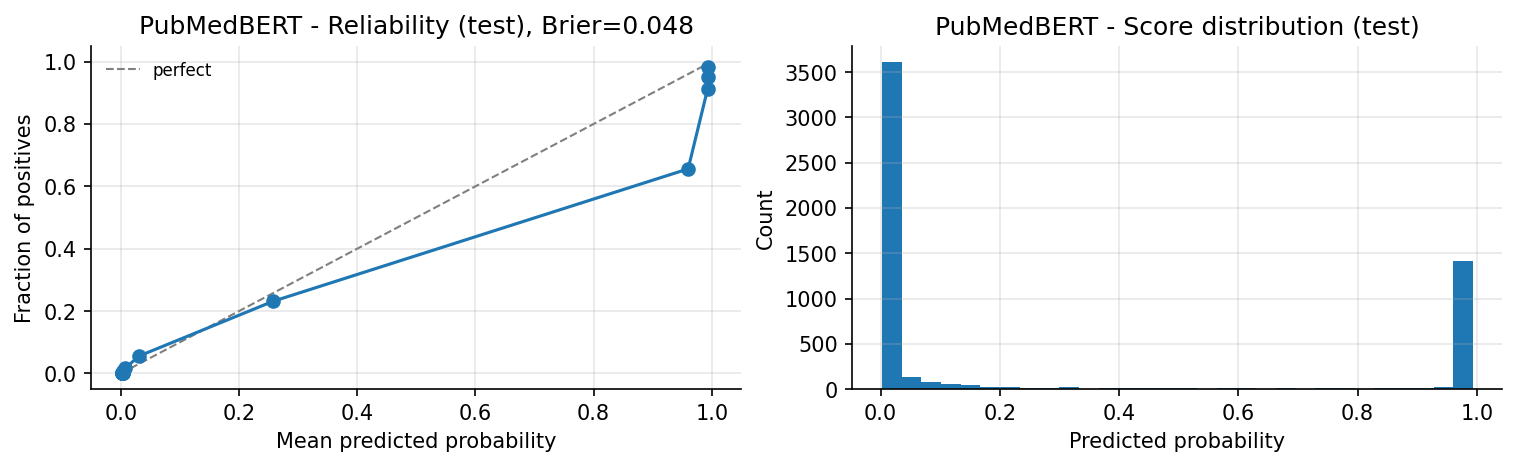

Saved: /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/plots/pubmed_test_calib_and_hist.png


In [ ]:
prob_true, prob_pred = calibration_curve(d_test_y, d_test_p, n_bins=15, strategy="quantile")
brier = brier_score_loss(d_test_y, d_test_p)

fig, axes = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)

ax = axes[0]
ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1, color="gray", label="perfect")
ax.plot(prob_pred, prob_true, marker="o")
ax.set_xlabel("Mean predicted probability"); ax.set_ylabel("Fraction of positives")
ax.set_title(f"PubMedBERT - Reliability (test), Brier={brier:.3f}")
ax.grid(alpha=0.3); ax.legend(frameon=False, fontsize=8)
for s in ("top", "right"): ax.spines[s].set_visible(False)

ax = axes[1]
ax.hist(d_test_p, bins=30, histtype="stepfilled")
ax.set_xlabel("Predicted probability"); ax.set_ylabel("Count")
ax.set_title("PubMedBERT - Score distribution (test)")
ax.grid(alpha=0.3)
for s in ("top", "right"): ax.spines[s].set_visible(False)

out_fig = PLOTS_DIR / "pubmed_test_calib_and_hist.png"
fig.savefig(out_fig, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out_fig)


Brier=0.048; reliability is close to the diagonal and slightly under-confident in the mid range.

Score histogram: Clear bimodal split—most non-ADE near 0 and many ADE near 1.

PubMedBERT is well-separated and well-calibrated; strong test performance under the recall-floor threshold.

# ***PubMedBERT: export top FP/FN examples***

In [ ]:
ERR_DIR = ensure_dir(TRANS_DIR / "errors")

df = test_df.reset_index(drop=True).copy()
df["y_true"] = d_test_y
df["y_prob"] = d_test_p
df["y_pred"] = (df["y_prob"] >= tv_pub_thr).astype(int)
df["err"] = np.where((df["y_true"]==0) & (df["y_pred"]==1), "FP",
              np.where((df["y_true"]==1) & (df["y_pred"]==0), "FN", ""))

id_col = "uid" if "uid" in df.columns else None
cols = ([id_col] if id_col else []) + [TEXT_COL, "y_true", "y_prob", "y_pred", "err"]

fp = (df[df.err=="FP"].sort_values("y_prob", ascending=False)
        .assign(text_snip=lambda x: x[TEXT_COL].astype(str).str.slice(0, 220)))
fn = (df[df.err=="FN"].sort_values("y_prob", ascending=True)
        .assign(text_snip=lambda x: x[TEXT_COL].astype(str).str.slice(0, 220)))

display(fp[cols + ["text_snip"]].head(10))
display(fn[cols + ["text_snip"]].head(10))

fp_path = ERR_DIR / "pubmedbert_test_fp_examples.csv"
fn_path = ERR_DIR / "pubmedbert_test_fn_examples.csv"
fp[cols + ["text_snip"]].to_csv(fp_path, index=False)
fn[cols + ["text_snip"]].to_csv(fn_path, index=False)
print("Saved:", fp_path, "|", fn_path)

print("\n#FP examples")
for x in fp[TEXT_COL].head(5):
    print("-", str(x)[:220])

print("\n#FN examples")
for x in fn[TEXT_COL].head(5):
    print("-", str(x)[:220])

,uid,text_clean,y_true,y_prob,y_pred,err,text_snip
4838,te_4838,Interferon-induced sarcoidosis is well documen...,0,0.993359,1,FP,Interferon-induced sarcoidosis is well documen...
2598,te_2598,"A patient using ziprasidone with polydipsia, s...",0,0.993346,1,FP,"A patient using ziprasidone with polydipsia, s..."
434,te_434,Tetracycline-induced renal hypophosphatemia in...,0,0.993333,1,FP,Tetracycline-induced renal hypophosphatemia in...
1134,te_1134,We present three prednisolone-treated boys wit...,0,0.993320,1,FP,We present three prednisolone-treated boys wit...
47,te_47,Cutaneous adverse reactions to 8-methoxypsoral...,0,0.993307,1,FP,Cutaneous adverse reactions to 8-methoxypsoral...
3792,te_3792,A 69-year-old woman developed Cushing's syndro...,0,0.993294,1,FP,A 69-year-old woman developed Cushing's syndro...
2318,te_2318,Drug eruption associated with sulfonamide trea...,0,0.993294,1,FP,Drug eruption associated with sulfonamide trea...
2664,te_2664,Upon rechallenge with clomiphene 3 months late...,0,0.993281,1,FP,Upon rechallenge with clomiphene 3 months late...
1225,te_1225,"During the course of treatment, photosensitisa...",0,0.993281,1,FP,"During the course of treatment, photosensitisa..."
726,te_726,"We report a patient diagnosed with B-CLL, prev...",0,0.993281,1,FP,"We report a patient diagnosed with B-CLL, prev..."


,uid,text_clean,y_true,y_prob,y_pred,err,text_snip
1315,te_1315,"A 65-year-old woman, in the intensive care uni...",1,0.002596,0,FN,"A 65-year-old woman, in the intensive care uni..."
3327,te_3327,We report an allogeneic bone marrow transplant...,1,0.003010,0,FN,We report an allogeneic bone marrow transplant...
4379,te_4379,Evaluation revealed elevated serum LTG levels ...,1,0.003254,0,FN,Evaluation revealed elevated serum LTG levels ...
2380,te_2380,Favorable outcome of de novo hepatitis B infec...,1,0.003463,0,FN,Favorable outcome of de novo hepatitis B infec...
4324,te_4324,She continued to receive regular insulin 4 tim...,1,0.003470,0,FN,She continued to receive regular insulin 4 tim...
1787,te_1787,Methotrexate is an effective but potentially t...,1,0.005060,0,FN,Methotrexate is an effective but potentially t...
2239,te_2239,"The disease-modifying drugs he was taking, cyc...",1,0.005354,0,FN,"The disease-modifying drugs he was taking, cyc..."
5353,te_5353,He was started on oral lansoprazole 60 mg twic...,1,0.005533,0,FN,He was started on oral lansoprazole 60 mg twic...
647,te_647,After abstinence from oolong tea his delirium ...,1,0.006327,0,FN,After abstinence from oolong tea his delirium ...
2939,te_2939,The patient continued to have fever and autono...,1,0.007121,0,FN,The patient continued to have fever and autono...


Saved: /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts/transformers/pubmedbert/errors/pubmedbert_test_fp_examples.csv | /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts/transformers/pubmedbert/errors/pubmedbert_test_fn_examples.csv

#FP examples
- Interferon-induced sarcoidosis is well documented.
- A patient using ziprasidone with polydipsia, seizure, hyponatremia and rhabdomyolysis.
- Tetracycline-induced renal hypophosphatemia in a patient with a syndrome of inappropriate secretion of antidiuretic hormone.
- We present three prednisolone-treated boys with myoglobinuria and in two cases this was recurrent.
- Cutaneous adverse reactions to 8-methoxypsoralen (8-MOP) appear to be rare and may be difficult to distinguish from phototoxicity or UV-induced polymorphic light eruption.

#FN examples
- A 65-year-old woman, in the intensive care unit because of septic shock and acute renal failure, had a small-bowel obstruct

# **CELL — final comparison table (VAL-chosen thresholds applied on TEST)**


In [ ]:
from pathlib import Path
import json, numpy as np, pandas as pd
from sklearn.metrics import (
    precision_recall_fscore_support, accuracy_score, confusion_matrix,
    average_precision_score, roc_auc_score
)

PROJECT_ROOT = Path("/content/drive/MyDrive/masters_math/capestone/Final_project/Final_project")
MODELS = {
    "distilbert": PROJECT_ROOT/"artifacts/transformers/distilbert",
    "biobert":    PROJECT_ROOT/"artifacts/transformers/biobert",
    "pubmedbert": PROJECT_ROOT/"artifacts/transformers/pubmedbert",
}

def _read_thr(p):
    blob = json.loads(p.read_text())
    # support multiple keys across notebooks
    return float(blob.get("best_threshold", blob.get("best_thr", blob.get("threshold", 0.5))))

def _load(model_dir: Path):
    val = pd.read_csv(model_dir/"preds/val_probs.csv")
    test = pd.read_csv(model_dir/"preds/test_probs.csv")
    thr = _read_thr(model_dir/"thresholds.json")
    yv, pv = val["y_true"].astype(int).to_numpy(), val["y_score"].to_numpy()
    yt, pt = test["y_true"].astype(int).to_numpy(), test["y_score"].to_numpy()
    return (yv, pv, yt, pt, thr)

def _metrics(y, s, thr):
    yhat = (s >= thr).astype(int)
    P, R, F1, _ = precision_recall_fscore_support(y, yhat, average="binary", zero_division=0)
    acc = accuracy_score(y, yhat)
    tn, fp, fn, tp = confusion_matrix(y, yhat, labels=[0,1]).ravel()
    ap  = average_precision_score(y, s)
    ra  = roc_auc_score(y, s)
    return dict(precision=P, recall=R, f1=F1, accuracy=acc, tn=int(tn), fp=int(fp), fn=int(fn), tp=int(tp), ap=ap, roc_auc=ra)

rows = []
for name, mdir in MODELS.items():
    if not (mdir/"preds/val_probs.csv").exists():
        continue
    yv, pv, yt, pt, thr = _load(mdir)
    mv = _metrics(yv, pv, thr)
    mt = _metrics(yt, pt, thr)
    rows.append({
        "model": name, "thr": thr,
        "VAL_P": mv["precision"], "VAL_R": mv["recall"], "VAL_F1": mv["f1"], "VAL_AP": mv["ap"], "VAL_AUC": mv["roc_auc"],
        "TEST_P": mt["precision"], "TEST_R": mt["recall"], "TEST_F1": mt["f1"], "TEST_Acc": mt["accuracy"],
        "TEST_FP": mt["fp"], "TEST_FN": mt["fn"]
    })

cmp_df = pd.DataFrame(rows).sort_values(["TEST_F1","TEST_P","TEST_R"], ascending=False)
display(cmp_df.style.format({c:"{:.3f}" for c in cmp_df.columns if c not in ["model","TEST_FP","TEST_FN"]}))
cmp_df


,model,thr,VAL_P,VAL_R,VAL_F1,VAL_AP,VAL_AUC,TEST_P,TEST_R,TEST_F1,TEST_Acc,TEST_FP,TEST_FN
1,biobert,0.777,0.837,0.905,0.870,0.936,0.984,0.896,0.900,0.898,0.948,149,143
2,pubmedbert,0.876,0.832,0.905,0.867,0.927,0.980,0.888,0.908,0.898,0.947,164,132
0,distilbert,0.548,0.769,0.905,0.832,0.901,0.975,0.821,0.890,0.854,0.923,277,158


,model,thr,VAL_P,VAL_R,VAL_F1,VAL_AP,VAL_AUC,TEST_P,TEST_R,TEST_F1,TEST_Acc,TEST_FP,TEST_FN
1,biobert,0.776644,0.837134,0.90493,0.869712,0.936137,0.984474,0.896312,0.900070,0.898187,0.948098,149,143
2,pubmedbert,0.875574,0.831715,0.90493,0.866779,0.927376,0.980226,0.887902,0.907757,0.897719,0.947387,164,132
0,distilbert,0.548250,0.769461,0.90493,0.831715,0.901197,0.975246,0.821290,0.889588,0.854076,0.922680,277,158
